### Introduction

LendingTree is an online lending exchange that connects consumers with multiple lenders, banks, and credit partners who compete for business. LendingTree is not a direct supplier of loans; it is instead a broker. We will be working with LendingTree’s data to explore one of the oldest prediction problems – predicting risk on consumer loans.

This notebook is used to:
* Develop a statistical model for predicting bad loans
* Use the model to identify the most important drivers of bad loans
* Make recommendations to avoid funding bad loans.

### Business Problem

Being as a broker, playing a role as the connection between the borrowers and lenders, there are many times a broker would like to have an overview of whether a loan can be approved by lenders or not. As a result, basing on the dataset collected by **LendingTree**, we can find out the important features affecting a loan and can foresee the chance of a loan to be approved.

### Explore the dataset

First, we need to read the dataset

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # this is used for the plot the graph 
import numpy as np
%matplotlib inline

In [2]:
full_data = pd.read_csv("loan_data.csv", skiprows=1)

/Users/admin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (0,112) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Then, let's see what kind of data we have in the dataset by list out all of the columns in the dataset

In [3]:
columns = list(full_data.columns.values)
print "Columns size:", len(columns)
columns

Columns size: 145


['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

In all of these columns, the outcome (what we want to predict) is the column called **grade**. It is the **Loan grade**. Based on each loan application and credit report, every loan is assigned a grade ranging from A1 to E5. 

We will ignore the column **sub_grade** because basing on only grade, we can evaluate a loan.

In [4]:
full_data.drop(['sub_grade'], axis=1, inplace=True)
outcome = full_data[['grade']]
outcome.head(5)

,grade
0,B
1,B
2,C
3,E
4,C


Let's see how many grade we have to evaluate

In [5]:
outcome['grade'].unique()

array(['B', 'C', 'E', 'A', 'D', 'G', 'F', nan], dtype=object)

There are two things we need to do with the outcome dataset:
* We have _nan_ value in our dataset, so we will drop all the row having the _nan_ value. 
* We need to transform all the outcome data into number so the model can understand it.

In [6]:
full_data = full_data[pd.notnull(full_data['grade'])]
map_grade = {"A":1,"B":2,"C":3,"D":4,"E":5,"F":6, 'G': 7}
full_data["grade"] = full_data["grade"].map(map_grade)
full_data['grade'].head(5)

0    2
1    2
2    3
3    5
4    3
Name: grade, dtype: int64

As we can see, now all the data relating to **grade** are transformed to number only. We have finished correct the outcome dataset.

### Clean up the dataset

We remove all the data indicating id because it is unique for every row. The column **url** and **desc** are empty for all rows, we should remove them too. Moreover, all the information that a borrower can not give out by himself/herself should be remove because the model is built to help the borrowers evaluate their ability for a loan.

In [7]:
full_data.drop(['id', 'member_id', 'url', 'desc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
               'title', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_record',
               'open_acc', 'pub_rec', 'total_acc', 'initial_list_status', 'recoveries', 'collection_recovery_fee',
               'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code',
               'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'revol_bal_joint', 'payment_plan_start_date',
               'debt_settlement_flag_date', 'settlement_date','verification_status_joint'], axis=1, inplace=True)

All the information relates to the loan after being funded is not considered too.

In [9]:
full_data.drop(['funded_amnt_inv', 'funded_amnt', 'out_prncp', 
               'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
               'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'last_pymnt_d', 'next_pymnt_d',
               'last_credit_pull_d'], axis=1, inplace=True)

KeyError: "labels ['funded_amnt_inv' 'funded_amnt' 'out_prncp' 'out_prncp_inv' 'total_pymnt'\n 'total_pymnt_inv' 'total_rec_prncp' 'total_rec_int' 'total_rec_late_fee'\n 'last_pymnt_amnt' 'last_pymnt_d' 'next_pymnt_d' 'last_credit_pull_d'] not contained in axis"

After cleaning up uncessary, let's see how many columns we have in the dataset.

In [10]:
columns = list(full_data.columns.values)
print "Columns size:", len(columns)
columns

Columns size: 103


['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'revol_bal',
 'revol_util',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'n

The **int_rate** is Interest Rate on the loan. It is decided based on the grade of the loan so we do not need this information too.

In [11]:
full_data.drop(['int_rate'], axis=1, inplace=True)

Next step, we will transform all categorical data into numbers because our model only understands numbers.

In [12]:
def convertEmploymentLength(l):
    if l == '< 1 year' or l == 'nan':
        return 0
    if l == '10+ years':
        return 10
    if l[1] == ' ':
        return (int)(l[:2])
    return (int)(l[:3])

def convert(data, listValue):
    return listValue.index(data)

def transformCategoricalData(df):
    result = df.copy()
    listPurpose = list(df['purpose'].unique())
    listOwnership = list(df['home_ownership'].unique())
    listAppType = list(df['application_type'].unique())
    listHardshipFlag = list(df['hardship_flag'].unique())
    listHSLoanStatus = list(df['hardship_loan_status'].unique())
    listDisbursement = list(df['disbursement_method'].unique())
    listDebtFlag = list(df['debt_settlement_flag'].unique())
    for index, row in result.iterrows():
        result.at[index, 'emp_length'] = convertEmploymentLength(row['emp_length'])
        result.at[index, 'purpose'] = convert(row.purpose, listPurpose)
        result.at[index, 'home_ownership'] = convert(row['home_ownership'], listOwnership)
        result.at[index, 'application_type'] = convert(row['application_type'], listAppType)
        result.at[index, 'hardship_flag'] = convert(row['hardship_flag'], listHardshipFlag)
        result.at[index, 'hardship_loan_status'] = convert(row['hardship_loan_status'], listHSLoanStatus)
        result.at[index, 'disbursement_method'] = convert(row['disbursement_method'], listDisbursement)
        result.at[index, 'debt_settlement_flag'] = convert(row['debt_settlement_flag'], listDebtFlag)
    return result

In [13]:
full_data['term'] = full_data['term'].apply(lambda x: x[:3])
full_data['emp_length'] = full_data['emp_length'].astype('str') 
full_data = transformCategoricalData(full_data)
full_data.head(5)

,loan_amnt,term,installment,grade,emp_title,emp_length,home_ownership,annual_inc,purpose,zip_code,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term
0,4600.0,36,151.45,2,cable technician,4,0,44470.0,0,066xx,...,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
1,15400.0,60,337.84,2,Social worker,10,1,95000.0,1,068xx,...,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2,14000.0,36,492.13,3,Project Leader,10,1,82000.0,0,672xx,...,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
3,5000.0,36,200.10,5,Pilot,10,1,215000.0,1,067xx,...,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
4,4700.0,36,165.22,3,RN Manager,10,1,100046.0,1,847xx,...,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN


After transforming all of categorical data, I figure out some more columns that we need to remove because it just give more details about other columns.

In [14]:
full_data.drop(['emp_title', 'settlement_status','hardship_loan_status', 'hardship_dpd',
               'hardship_end_date', 'hardship_start_date', 'deferral_term', 'hardship_status', 'zip_code', ], axis=1, inplace=True)

We drop features that contain too many NA values. Let's count the NA values of each feature.

In [15]:
nullData = full_data.isnull().sum()
nullData[nullData > 0]

dti                                              33
mths_since_last_delinq                        46293
revol_util                                       51
annual_inc_joint                              92372
dti_joint                                     92372
mths_since_rcnt_il                             2596
il_util                                       12998
all_util                                          3
bc_open_to_buy                                  985
bc_util                                        1028
mo_sin_old_il_acct                             2596
mths_since_recent_bc                            945
mths_since_recent_bc_dlq                      72987
mths_since_recent_inq                         11314
mths_since_recent_revol_delinq                62320
num_tl_120dpd_2m                               4706
sec_app_earliest_cr_line                      95754
sec_app_inq_last_6mths                        95754
sec_app_mort_acc                              95754
sec_app_open

We have **96779** rows in our dataset but we can see that there are many features having NA values for over **90000** rows. So we will drop all the columns having NA values for over 90000 rows.

In [16]:
drop_columns = nullData[nullData > 90000].keys()
full_data.drop(drop_columns, axis=1, inplace=True)
full_data.head(5)

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,...,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,4600.0,36,151.45,2,4,0,44470.0,0,CT,13.43,...,2.0,0.0,0.0,40000.0,9625.0,14500.0,11700.0,0,0,0
1,15400.0,60,337.84,2,10,1,95000.0,1,CT,11.52,...,2.0,0.0,0.0,579945.0,158331.0,25800.0,143395.0,0,0,0
2,14000.0,36,492.13,3,10,1,82000.0,0,KS,31.07,...,0.0,0.0,0.0,286204.0,104008.0,81400.0,60167.0,0,0,0
3,5000.0,36,200.10,5,10,1,215000.0,1,CT,6.06,...,4.0,0.0,0.0,100763.0,44754.0,46200.0,49814.0,0,0,0
4,4700.0,36,165.22,3,10,1,100046.0,1,UT,12.37,...,1.0,0.0,0.0,353570.0,49114.0,3500.0,58668.0,0,0,0


Now let's explore the columns that have less NA values to decide whehter we should keep them or not

In [17]:
nullData = full_data.isnull().sum()
nullData[nullData > 0]

dti                                  33
mths_since_last_delinq            46293
revol_util                           51
mths_since_rcnt_il                 2596
il_util                           12998
all_util                              3
bc_open_to_buy                      985
bc_util                            1028
mo_sin_old_il_acct                 2596
mths_since_recent_bc                945
mths_since_recent_bc_dlq          72987
mths_since_recent_inq             11314
mths_since_recent_revol_delinq    62320
num_tl_120dpd_2m                   4706
dtype: int64

We will remove the **mths_since_last_delinq**, **mths_since_recent_bc_dlq** and **mths_since_recent_revol_delinq**. These information are not valuable enough and they have a lot of NA values.

In [18]:
full_data.drop(['revol_util', 'mths_since_last_delinq', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq'],
               axis=1, inplace=True)

In [19]:
nullData = full_data.isnull().sum()
nullData[nullData > 0]

dti                         33
mths_since_rcnt_il        2596
il_util                  12998
all_util                     3
bc_open_to_buy             985
bc_util                   1028
mo_sin_old_il_acct        2596
mths_since_recent_bc       945
mths_since_recent_inq    11314
num_tl_120dpd_2m          4706
dtype: int64

First, let's talk about **dti**. **DTI** is considered one of the most important factor for lender to decide. That's why for all the rows not having value of dti, we remove them all.

In [20]:
full_data = full_data[pd.notnull(full_data['dti'])]

In [21]:
nullData = full_data.isnull().sum()
nullData[nullData > 0]

mths_since_rcnt_il        2593
il_util                  12987
all_util                     3
bc_open_to_buy             985
bc_util                   1028
mo_sin_old_il_acct        2593
mths_since_recent_bc       945
mths_since_recent_inq    11309
num_tl_120dpd_2m          4706
dtype: int64

All other columns, the **NA** value will be replaced by the mean value of the whole columns

In [22]:
nullData = nullData[nullData > 0]
for key in nullData.keys():
        full_data[key].fillna((full_data[key].mean()), inplace=True)

Let's see whether we have any columns having **NA** value.

In [23]:
nullData = full_data.isnull().sum()
nullData[nullData > 0]

Series([], dtype: int64)

Now we have cleaned up the dataset.

### Building Model
#### Model built by trying correlation for feature selection

In [24]:
columns = list(full_data.columns.values)
columns.remove('grade')
list_feature = {}
for col in columns:
    if full_data[col].dtype == 'object':
        continue
    correlation = full_data['grade'].corr(full_data[col])
    if correlation != 0:
        list_feature[abs(correlation)] = col

list_feature

{0.002620786330149851: 'num_tl_120dpd_2m',
 0.002868032739389746: 'total_bal_il',
 0.0035222474192166155: 'tot_coll_amt',
 0.0035585925454921143: 'delinq_amnt',
 0.0036375973043233545: 'open_act_il',
 0.004023268027440389: 'acc_now_delinq',
 0.004292827266843358: 'num_tl_30dpd',
 0.006582131284631973: 'chargeoff_within_12_mths',
 0.006670490590471688: 'num_il_tl',
 0.008411574606899636: 'num_sats',
 0.008874350070645975: 'total_bal_ex_mort',
 0.01021101360921158: 'num_op_rev_tl',
 0.013069087108569053: 'tax_liens',
 0.016008845532249506: 'num_bc_sats',
 0.018579573825558273: 'total_cu_tl',
 0.02100474562285495: 'num_tl_90g_dpd_24m',
 0.023471881436637122: 'revol_bal',
 0.024689047082319233: 'delinq_2yrs',
 0.02913894314658161: 'total_il_high_credit_limit',
 0.03537705174322993: 'annual_inc',
 0.040452044135531905: 'num_accts_ever_120_pd',
 0.046063934217445625: 'num_rev_accts',
 0.05269589449633636: 'mths_since_rcnt_il',
 0.05680901163814786: 'max_bal_bc',
 0.0579411790142707: 'num_act

Now we have a list of correlation of each feature. Now we need to sort this list descending so we always try the best correlation first.

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

def calculateAccuracy(features, data, outcome):
    X = pd.DataFrame(data, columns=features)
    y = data[outcome]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    logistic = LogisticRegression()
    logistic.fit(X_train, y_train)
    return accuracy_score(y_test, logistic.predict(X_test))

def calculateAccuracyRF(features, data, outcome):
    X = pd.DataFrame(data, columns=features)
    y = data[outcome]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    random_forest = RandomForestClassifier(max_depth=10, random_state=0)
    random_forest.fit(X_train, y_train)
    prediction = random_forest.predict(X_test)
    print confusion_matrix(y_test, prediction)
    return accuracy_score(y_test, prediction)

In [397]:
correlation = list_feature.keys()
correlation.sort(reverse=True)

test_list_feature = [list_feature[x] for x in correlation[:10]]
results_LR = []
test_data = full_data.head(5000)
for i in range(11, len(correlation)):
    test_list_feature.append(list_feature[correlation[i]])
    results_LR.append(calculateAccuracy(test_list_feature, test_data, 'grade'))


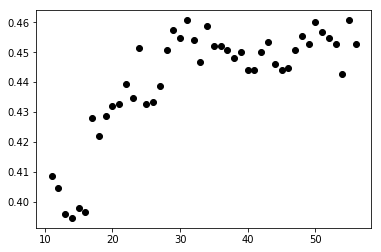

In [400]:
x = range(11, len(results_LR)+11)
y = results_LR
plt.plot(x, y, 'o', color='black');

In [401]:
test_list_feature = [list_feature[x] for x in correlation[:10]]
results_RF = []
test_data = full_data.head(5000)
for i in range(11, len(correlation)):
    test_list_feature.append(list_feature[correlation[i]])
    results_RF.append(calculateAccuracyRF(test_list_feature, test_data, 'grade'))

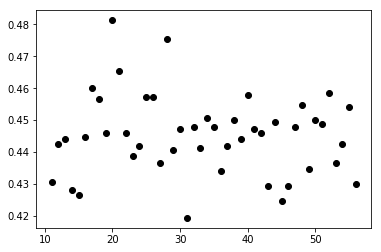

In [402]:
x = range(11, len(results_RF)+11)
y = results_RF
plt.plot(x, y, 'o', color='black');

### Model bulit by modifying outcomes into binary outcomes

In [32]:
def transformGrade(value, row):
    if row['grade'] == value:
        return 1
    else:
        return 0

In [33]:
full_data['grade_A'] = full_data.apply (lambda row: transformGrade(1, row),axis=1)
full_data['grade_B'] = full_data.apply (lambda row: transformGrade(2, row),axis=1)
full_data['grade_C'] = full_data.apply (lambda row: transformGrade(3, row),axis=1)
full_data['grade_D'] = full_data.apply (lambda row: transformGrade(4, row),axis=1)
full_data['grade_E'] = full_data.apply (lambda row: transformGrade(5, row),axis=1)
full_data['grade_F'] = full_data.apply (lambda row: transformGrade(6, row),axis=1)
full_data['grade_G'] = full_data.apply (lambda row: transformGrade(7, row),axis=1)

In [417]:
def tryCorrelation(outcome, useRF):
    correlation = list_feature.keys()
    correlation.sort(reverse=True)

    test_list_feature = [list_feature[x] for x in correlation[:10]]
    results_LR = []
    test_data = full_data.head(5000)
    for i in range(11, len(correlation)):
        test_list_feature.append(list_feature[correlation[i]])
        if useRF:
            results_LR.append(calculateAccuracyRF(test_list_feature, test_data, outcome))
        else:
            results_LR.append(calculateAccuracy(test_list_feature, test_data, outcome))
    x = range(11, len(results_LR)+11)
    y = results_RF
    plt.plot(x, y, 'o', color='black');

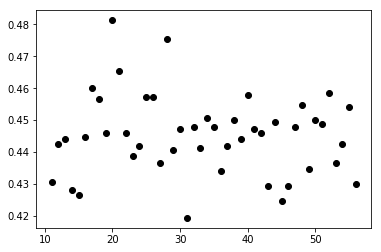

In [424]:
tryCorrelation('grade_C', False)

In [46]:
from sklearn.linear_model import RandomizedLasso
from sklearn.feature_selection import RFE
#using the Boston housing data. 
#Data gets scaled automatically by sklearn's implementation
data = full_data.head(5000)
X = pd.DataFrame(data, columns=list_feature.values())
y = data['grade']
 
#use linear regression as the model
lr = LogisticRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,y)

print "Features sorted by their rank:"
map_ranking = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), list(X.columns.values)))

KeyboardInterrupt: 

In [75]:
ranking, feature =  zip(*map_ranking)
map_ranking

[(1.0, 'acc_now_delinq'),
 (2.0, 'chargeoff_within_12_mths'),
 (3.0, 'open_il_12m'),
 (4.0, 'pub_rec_bankruptcies'),
 (5.0, 'open_acc_6m'),
 (6.0, 'tax_liens'),
 (7.0, 'num_tl_90g_dpd_24m'),
 (8.0, 'acc_open_past_24mths'),
 (9.0, 'num_sats'),
 (10.0, 'open_act_il'),
 (11.0, 'num_op_rev_tl'),
 (12.0, 'open_il_24m'),
 (13.0, 'delinq_2yrs'),
 (14.0, 'num_rev_tl_bal_gt_0'),
 (15.0, 'open_rv_24m'),
 (16.0, 'open_rv_12m'),
 (17.0, 'num_tl_op_past_12m'),
 (18.0, 'inq_fi'),
 (19.0, 'num_actv_rev_tl'),
 (20.0, 'num_accts_ever_120_pd'),
 (21.0, 'mort_acc'),
 (22.0, 'delinq_amnt'),
 (23.0, 'num_bc_sats'),
 (24.0, 'num_actv_bc_tl'),
 (25.0, 'num_bc_tl'),
 (26.0, 'inq_last_12m'),
 (27.0, 'mths_since_rcnt_il'),
 (28.0, 'mo_sin_rcnt_tl'),
 (29.0, 'mo_sin_rcnt_rev_tl_op'),
 (30.0, 'total_cu_tl'),
 (31.0, 'num_il_tl'),
 (32.0, 'tot_coll_amt'),
 (33.0, 'num_rev_accts'),
 (34.0, 'mths_since_recent_inq'),
 (35.0, 'mths_since_recent_bc'),
 (36.0, 'dti'),
 (37.0, 'bc_util'),
 (38.0, 'il_util'),
 (39.0, 'all

In [76]:
list_top_feature = []
for i in range(0, len(ranking)):
    if ranking[i] >= 36:
        list_top_feature.append(feature[i])
        
list_top_feature

['dti',
 'bc_util',
 'il_util',
 'all_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'installment',
 'loan_amnt',
 'revol_bal',
 'total_rev_hi_lim',
 'max_bal_bc',
 'total_bc_limit',
 'avg_cur_bal',
 'tot_cur_bal',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bal_il',
 'bc_open_to_buy',
 'num_tl_30dpd',
 'total_il_high_credit_limit',
 'annual_inc',
 'num_tl_120dpd_2m']

In [77]:
calculateAccuracy(list_top_feature, full_data, 'grade')

0.4236493936052922

In [78]:
calculateAccuracyRF(list_top_feature, full_data, 'grade')

0.4720576074972437

In [94]:
calculateAccuracyRF(list_top_feature, full_data, 'grade_A')

[[23984   486]
 [ 3486  1068]]


0.8631477398015436

In [95]:
calculateAccuracyRF(list_top_feature, full_data, 'grade_B')

[[20207   134]
 [ 7595  1088]]


0.7337031422271224

In [97]:
calculateAccuracyRF(list_top_feature, full_data, 'grade_C')

[[18567   415]
 [ 8387  1655]]


0.6967337375964718

In [98]:
calculateAccuracyRF(list_top_feature, full_data, 'grade_D')

[[25495    22]
 [ 3366   141]]


0.8832690187431091

In [99]:
calculateAccuracyRF(list_top_feature, full_data, 'grade_E')

[[27472     0]
 [ 1543     9]]


0.9468371003307607

In [100]:
calculateAccuracyRF(list_top_feature, full_data, 'grade_F')

[[28480     6]
 [  526    12]]


0.981670341786108

In [101]:
calculateAccuracyRF(list_top_feature, full_data, 'grade_G')

[[28876     0]
 [  146     2]]


0.9949696802646086